In [5]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import sys
print(sys.version)
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image

from tensorboardX import SummaryWriter
from tqdm import tqdm
from copy import deepcopy


from utils import *
from models import *
from fid_score import *
from inception_score import *

from real_imgs import *

3.9.5 (v3.9.5:0a7dcbdb13, May  3 2021, 13:17:02) 
[Clang 6.0 (clang-600.0.57)]
['/Users/ryomacmini/work/codes/MNIST_Calculator/calculator', '/Users/ryomacmini/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles', '/Users/ryomacmini/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles/lib/python', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages', '/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages/IPython/extensions', '/Users/ryomacmini/.ipython']


# ロードした画像の表示を試す。
(1)ローカルにある画像を表示すること<br>
(2)RGBではなくグレースケールにすること<br>
(3)28.28にreshapeすること→なぜかRGB最小が0にならなかったので、そもそも28pixで画像を準備<br>

PNG (28, 28) RGBA
((0, 255), (0, 255), (0, 255), (255, 255))
(255, 255, 255, 255)


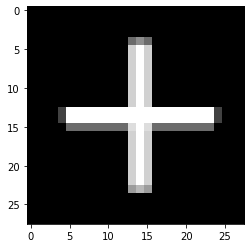

In [6]:
from PIL import Image, ImageFilter

im = Image.open('img/addition28pix.png')
plt.imshow(np.array(im))
print(im.format, im.size, im.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(im.getextrema()) #RGB各色の最小値と最大値を取得。
print(im.getpixel((14,14 ))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

None (28, 28) L
(0, 255)
255


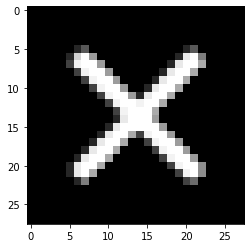

In [7]:
im2 = Image.open('img/multiplication28pix.png')
new_im = im2.convert('L')
plt.imshow(np.array(new_im), cmap='gray')
print(new_im.format, new_im.size, new_im.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(new_im.getextrema()) #RGB各色の最小値と最大値を取得。
print(new_im.getpixel((14, 14))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

None (28, 28) L
(0, 255)
0


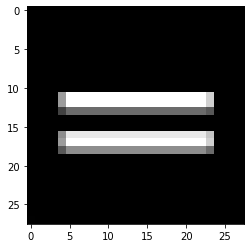

In [8]:
im3 = Image.open('img/equal28pix.png')
im3 = im3.convert('L')
im3 = im3.resize((28, 28))
plt.imshow(np.array(im3), cmap='gray')

print(im3.format, im3.size, im3.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(im3.getextrema()) #RGB各色の最小値と最大値を取得。
print(im3.getpixel((12, 10))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

### ＜参考＞resizeしたら、最小となっているところが"0"=完全黒にならなかった

None (28, 28) L
(12, 255)
255


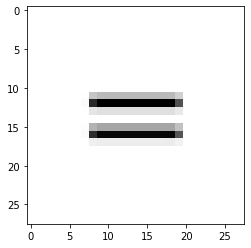

In [9]:
im4 = Image.open('img/equal.png')
im4 = im4.convert('L')
im4 = im4.resize((28, 28))
plt.imshow(np.array(im4), cmap='gray')

print(im4.format, im4.size, im4.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
#None (28, 28) L

print(im4.getextrema()) #RGB各色の最小値と最大値を取得。
#(12, 255)

print(im4.getpixel((1, 1))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。
#255

# MNISTから画像を表示してみる

### データをダウンロードする

In [10]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=len(trainset),shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

print(type(transform))
print(type(trainset))
print(type(testset))

trainset_not_transform = torchvision.datasets.MNIST(root='./data', train=True,download=True)
testset_not_transform = torchvision.datasets.MNIST(root='./data', train=False, download=True)
print(type(trainset_not_transform))
print(type(testset_not_transform))


<class 'torchvision.transforms.transforms.Compose'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>


/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### trainloaderの中身を見る

In [11]:
data_iter = iter(trainloader)
images, labels = data_iter.next()

<built-in method type of Tensor object at 0x7ff0b8b0f280>
torch.Size([60000, 1, 28, 28])
60000
------------------------
<built-in method type of Tensor object at 0x7ff0b8e80e80>
torch.Size([60000])
60000
------------------------
torch.Size([1, 28, 28])
------------------------
Label: tensor(5)


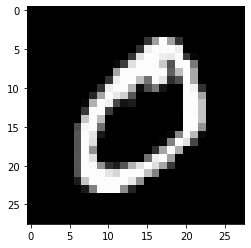

In [12]:
# matplotlibで1つ目のデータを可視化してみる
print(images.type)
print(images.size())
print(len(images))
print("------------------------")
print(labels.type)
print(labels.size())
print(len(labels))
print("------------------------")
print(images[1].size())
print("------------------------")
npimg = images[1].numpy()
npimg = npimg.reshape((28, 28))
plt.imshow(npimg, cmap='gray')
print('Label:', labels[0])

### testloaderの中身を見る

In [13]:
testloader_iter= iter(testloader)
images2, labels2 = testloader_iter.next()

<built-in method type of Tensor object at 0x7ff0d8a39240>
torch.Size([10000, 1, 28, 28])
10000
------------------------
<built-in method type of Tensor object at 0x7ff0c8afe200>
torch.Size([10000])
10000
------------------------
torch.Size([1, 28, 28])
------------------------
Label: tensor(7)


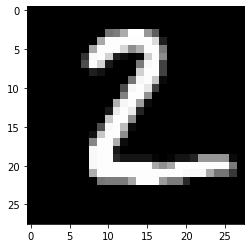

In [14]:
# matplotlibで1つ目のデータを可視化してみる
print(images2.type)
print(images2.size())
print(len(images2))
print("------------------------")
print(labels2.type)
print(labels2.size())
print(len(labels2))
print("------------------------")
print(images2[1].size())
print("------------------------")
npimg2 = images2[1].numpy()
npimg2 = npimg2.reshape((28, 28))
plt.imshow(npimg2, cmap='gray')
print('Label:', labels2[0])

# 試行錯誤

### 桁数をコントロールする方法をマスターする

In [15]:
X_digit = 2
Y_digit = 2

X = random.randrange(10**(X_digit-1),10**X_digit) #指定の桁数の中で乱数が出る
Y = random.randrange(10**(Y_digit-1),10**Y_digit) #指定の桁数の中で乱数が出る
Z = X*Y

print(X,Y,Z)
print('Xの桁数は',len(str(X)),\
      'Yの桁数は',len(str(Y)),\
      'Zの桁数は',len(str(Z)))

88 45 3960
Xの桁数は 2 Yの桁数は 2 Zの桁数は 4


### 数字を指定すれば、指定の画像が取ってこれるようになろう

In [16]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=len(trainset),shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

print(type(transform))
print(type(trainset))
print(type(testset))

trainset_not_transform = torchvision.datasets.MNIST(root='./data', train=True,download=True)
testset_not_transform = torchvision.datasets.MNIST(root='./data', train=False, download=True)
print(type(trainset_not_transform))
print(type(testset_not_transform))

trainloader_iter = iter(trainloader)
train_images, train_labels = trainloader_iter.next()


<class 'torchvision.transforms.transforms.Compose'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>


In [18]:
MNIST_dict = {i: [] for i in range(10)}
MNIST_dict

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [20]:
for i in range(len(train_images)):
    if train_labels[i] == 1:
        MNIST_dict[1].append(train_images[i])

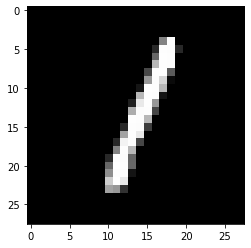

In [30]:
test1 = MNIST_dict[1][1284].numpy()
test1 = test1.reshape((28, 28))
plt.imshow(test1, cmap='gray')

In [31]:
for i in range(len(train_images)):
    if train_labels[i] == 0:
        MNIST_dict[0].append(train_images[i])
    if train_labels[i] == 1:
        MNIST_dict[1].append(train_images[i])
    if train_labels[i] == 2:
        MNIST_dict[2].append(train_images[i])
    if train_labels[i] == 3:
        MNIST_dict[3].append(train_images[i])
    if train_labels[i] == 4:
        MNIST_dict[4].append(train_images[i])
    if train_labels[i] == 5:
        MNIST_dict[5].append(train_images[i])
    if train_labels[i] == 6:
        MNIST_dict[6].append(train_images[i])
    if train_labels[i] == 7:
        MNIST_dict[7].append(train_images[i])
    if train_labels[i] == 8:
        MNIST_dict[8].append(train_images[i])
    if train_labels[i] == 9:
        MNIST_dict[9].append(train_images[i])

In [38]:
print(len(MNIST_dict[0]))
print(len(MNIST_dict[1]))
print(len(MNIST_dict[2]))
print(len(MNIST_dict[3]))
print(len(MNIST_dict[4]))
print(len(MNIST_dict[5]))
print(len(MNIST_dict[6]))
print(len(MNIST_dict[7]))
print(len(MNIST_dict[8]))
print(len(MNIST_dict[9]))

5923
13484
5958
6131
5842
5421
5918
6265
5851
5949


## 次はここから！！！！
やること：<br>
・乱数を指定し、画像を取ってくる。seedな方が良いかもしれない。<br>
・指定の数字の画像を取ってこれるようにするはX_digitとする。<br>
・画像を横向きでくっつける<br>
・指定のGoogleDriveのディレクトリに画像を保存する


In [ ]:
import random  
random.seed(123)
a = random.random()

0.052363598850944326

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

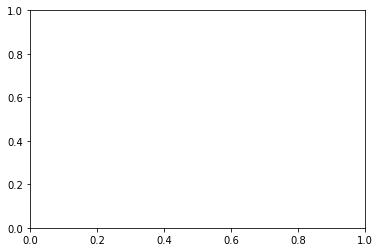

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

img = ('img/addition.png')
plt.imread(img)
# plt.show(img)
# ax.imshow(img)

In [ ]:
for i, data in enumerate(testloader):
    x, y = data
    print(x)
    print(y)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [ ]:
x.shape

torch.Size([10000, 1, 28, 28])

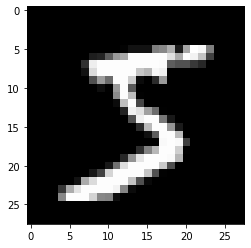

In [ ]:
for i,labels in enumerate(trainset):
    if i < 10:
        # print(images)
        npimg = images[0].numpy()
        npimg = npimg.reshape((28, 28))
        plt.imshow(npimg, cmap='gray')
        # plt.imshow(labels[0])
        # plt.show()
        # print(labels[1])
    if i > 10:
        break

In [ ]:
trainset_not_transform[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FB9614D81C0>, 5)

i:0
<class 'torch.Tensor'>
torch.Size([10000, 1, 28, 28])
torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

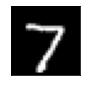

In [ ]:
H = 10
W = 10
fig = plt.figure(figsize=(H, W))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1.0, hspace=0.05, wspace=0.05)

for i, (images, labels) in enumerate(testloader, 0):

  n = images[0]*255
  #n = images[0]
  #print(n)
  
  numpy_array = n.numpy()

  ax = fig.add_subplot(H, W, i + 1, xticks=[], yticks=[])
  ax.imshow(numpy_array.reshape((28, 28)), cmap='gray')

  if i==0:
    print("i:{}".format(i))
    print(type(images))
    print(images.size())
    print(images[0].size())
    print(images[0])
    print(numpy_array)

    print(type(labels))
    print(labels)
    print(labels.size())

  if i >= 99:
    break

In [ ]:
#後に必要そうなコード　ファイルを保存
fname = "test1".png"
fig.savefig(fname, dpi = 64,
    facecolor = "lightgray", tight_layout = True)




SyntaxError: EOL while scanning string literal (2058927125.py, line 2)